In [59]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import shutil
import os

In [2]:
train_image_dir = 'E:\\DL_datasets\\cifar10\\preprocess_train'
test_image_dir = 'E:\\DL_datasets\\cifar10\\test'

train_transform = transforms.Compose([
    transforms.Resize(40),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(train_image_dir, transform=train_transform)
test_dataset = ImageFolder(test_image_dir, transform=test_transform)

In [46]:
len(train_dataset)

50000

In [48]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

In [51]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [52]:
def conv3x3(in_channels, out_channels, kernel_size=3, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)

In [53]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                nn.BatchNorm2d(out_channels))
        else:
            self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        return out

In [54]:
test_net = ResidualBlock(64, 128, 2)
test_x = Variable(torch.zeros(1, 64, 96, 96))
print('input:{}'.format(test_x.shape))

test_y = test_net(test_x)
print('output:{}'.format(test_y.shape))

input:torch.Size([1, 64, 96, 96])
output:torch.Size([1, 128, 48, 48])


In [55]:
class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()  # b, 3, 32, 32
        self.first = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(3, 1, 1)) # b, 64, 
        self.layer1 = self.make_layer(block, 64, 64, 3, 1)
        self.layer2 = self.make_layer(block, 64, 128, 4, 2)
        self.layer3 = self.make_layer(block, 128, 256, 6, 2)
        self.layer4 = self.make_layer(block, 256, 512, 3, 2)
        self.avg_pool = nn.AvgPool2d(2)
        self.fc = nn.Linear(512, 10)
        
    def make_layer(self, block, in_channels, out_channels, block_num, stride):
        layers = []
        layers.append(block(in_channels, out_channels, stride))
        for i in range(block_num - 1):
            layers.append(block(out_channels, out_channels, 1))
        return nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.first(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        return out

In [57]:
batch_size = 64
learning_rate = 1e-2
epochs = 50

model = ResNet(ResidualBlock)
if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0
    for data, label in tqdm(train_loader):
        data = data.view(data.size(0), 3, 32, 32)
        if torch.cuda.is_available():
            data = Variable(data).cuda()
            label = Variable(label).cuda()
        else:
            data = Variable(data)
            label = Variable(label)
        
        out = model(data)
        loss = criterion(out, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item() * label.size(0)
        _, pred = torch.max(out, 1)
        train_acc += (pred == label).sum().item()
    
    val_loss = 0.0
    val_acc = 0
    for data, label in val_loader:
        data = data.view(data.size(0), 3, 32, 32)
        if torch.cuda.is_available():
            data = Variable(data).cuda()
            label = Variable(label).cuda()
        else:
            data = Variable(data)
            label = Variable(label)
        
        out = model(data)
        loss = criterion(out, label)
        val_loss += loss.data.item() * label.size(0)
        _, pred = torch.max(out, 1)
        val_acc += (pred == label).sum().item()
    
    train_losses.append(train_loss/len(train_dataset))
    train_accs.append(train_acc/len(train_dataset))
    val_losses.append(val_loss/len(val_dataset))
    val_accs.append(val_acc/len(val_dataset))
    print("Epoch [{}/{}], train_loss:{:.6f}, train_acc:{:.6f}; val_loss:{:.6f}, val_acc:{:.6f}".format(epoch+1, epochs, 
                                            train_loss/len(train_dataset), train_acc/len(train_dataset),
                                            val_loss/len(val_dataset), val_acc/len(val_dataset)))

100%|███████████████████████████████| 625/625 [02:45<00:00,  3.78it/s]


Epoch [1/50], train_loss:2.670547, train_acc:0.420150; val_loss:1.960924, val_acc:0.502700


100%|███████████████████████████████| 625/625 [02:36<00:00,  4.00it/s]


Epoch [2/50], train_loss:1.660545, train_acc:0.553150; val_loss:1.444959, val_acc:0.592800


100%|███████████████████████████████| 625/625 [02:44<00:00,  3.80it/s]


Epoch [3/50], train_loss:1.294951, train_acc:0.624550; val_loss:1.257279, val_acc:0.626800


100%|███████████████████████████████| 625/625 [02:45<00:00,  3.77it/s]


Epoch [4/50], train_loss:1.100719, train_acc:0.663075; val_loss:1.066235, val_acc:0.668100


100%|███████████████████████████████| 625/625 [02:42<00:00,  3.85it/s]


Epoch [5/50], train_loss:0.979209, train_acc:0.691550; val_loss:0.979901, val_acc:0.692800


100%|███████████████████████████████| 625/625 [02:44<00:00,  3.80it/s]


Epoch [6/50], train_loss:0.891958, train_acc:0.714125; val_loss:0.912945, val_acc:0.706800


100%|███████████████████████████████| 625/625 [02:42<00:00,  3.85it/s]


Epoch [7/50], train_loss:0.823049, train_acc:0.733600; val_loss:0.899381, val_acc:0.709700


100%|███████████████████████████████| 625/625 [02:42<00:00,  3.84it/s]


Epoch [8/50], train_loss:0.763869, train_acc:0.749250; val_loss:0.842068, val_acc:0.727000


100%|███████████████████████████████| 625/625 [02:42<00:00,  3.85it/s]


Epoch [9/50], train_loss:0.719424, train_acc:0.762475; val_loss:0.832406, val_acc:0.729500


100%|███████████████████████████████| 625/625 [02:42<00:00,  3.85it/s]


Epoch [10/50], train_loss:0.693588, train_acc:0.769475; val_loss:0.777108, val_acc:0.748900


100%|███████████████████████████████| 625/625 [02:43<00:00,  3.83it/s]


Epoch [11/50], train_loss:0.651575, train_acc:0.781525; val_loss:0.745500, val_acc:0.759000


100%|███████████████████████████████| 625/625 [02:43<00:00,  3.83it/s]


Epoch [12/50], train_loss:0.615856, train_acc:0.792300; val_loss:0.709281, val_acc:0.768200


100%|███████████████████████████████| 625/625 [02:42<00:00,  3.84it/s]


Epoch [13/50], train_loss:0.595191, train_acc:0.799400; val_loss:0.712122, val_acc:0.766000


100%|███████████████████████████████| 625/625 [02:43<00:00,  3.83it/s]


Epoch [14/50], train_loss:0.569376, train_acc:0.806525; val_loss:0.695486, val_acc:0.776400


100%|███████████████████████████████| 625/625 [02:44<00:00,  3.80it/s]


Epoch [15/50], train_loss:0.542258, train_acc:0.817200; val_loss:0.678402, val_acc:0.772300


100%|███████████████████████████████| 625/625 [02:50<00:00,  3.67it/s]


Epoch [16/50], train_loss:0.525233, train_acc:0.822975; val_loss:0.655147, val_acc:0.783300


100%|███████████████████████████████| 625/625 [02:47<00:00,  3.73it/s]


Epoch [17/50], train_loss:0.501928, train_acc:0.829100; val_loss:0.659518, val_acc:0.782400


100%|███████████████████████████████| 625/625 [02:52<00:00,  3.63it/s]


Epoch [18/50], train_loss:0.481383, train_acc:0.836800; val_loss:0.661665, val_acc:0.786900


100%|███████████████████████████████| 625/625 [02:44<00:00,  3.81it/s]


Epoch [19/50], train_loss:0.460351, train_acc:0.842375; val_loss:0.646282, val_acc:0.792300


100%|███████████████████████████████| 625/625 [02:44<00:00,  3.80it/s]


Epoch [20/50], train_loss:0.449584, train_acc:0.846725; val_loss:0.640982, val_acc:0.794400


100%|███████████████████████████████| 625/625 [02:50<00:00,  3.66it/s]


Epoch [21/50], train_loss:0.436292, train_acc:0.851900; val_loss:0.625926, val_acc:0.798200


100%|███████████████████████████████| 625/625 [02:42<00:00,  3.84it/s]


Epoch [22/50], train_loss:0.418281, train_acc:0.856925; val_loss:0.614317, val_acc:0.803500


100%|███████████████████████████████| 625/625 [02:43<00:00,  3.82it/s]


Epoch [23/50], train_loss:0.406525, train_acc:0.861325; val_loss:0.627109, val_acc:0.799800


100%|███████████████████████████████| 625/625 [02:42<00:00,  3.85it/s]


Epoch [24/50], train_loss:0.400486, train_acc:0.861450; val_loss:0.615404, val_acc:0.804300


100%|███████████████████████████████| 625/625 [02:41<00:00,  3.86it/s]


Epoch [25/50], train_loss:0.379670, train_acc:0.868850; val_loss:0.629404, val_acc:0.803600


100%|███████████████████████████████| 625/625 [02:41<00:00,  3.86it/s]


Epoch [26/50], train_loss:0.370150, train_acc:0.873175; val_loss:0.609608, val_acc:0.807800


100%|███████████████████████████████| 625/625 [02:42<00:00,  3.85it/s]


Epoch [27/50], train_loss:0.361717, train_acc:0.876850; val_loss:0.610317, val_acc:0.807800


100%|███████████████████████████████| 625/625 [02:41<00:00,  3.86it/s]


Epoch [28/50], train_loss:0.345001, train_acc:0.880175; val_loss:0.630814, val_acc:0.802500


100%|███████████████████████████████| 625/625 [02:46<00:00,  3.76it/s]


Epoch [29/50], train_loss:0.340853, train_acc:0.882450; val_loss:0.587049, val_acc:0.817700


100%|███████████████████████████████| 625/625 [02:47<00:00,  3.74it/s]


Epoch [30/50], train_loss:0.323888, train_acc:0.888650; val_loss:0.594194, val_acc:0.815900


100%|███████████████████████████████| 625/625 [02:45<00:00,  3.77it/s]


Epoch [31/50], train_loss:0.313861, train_acc:0.891950; val_loss:0.618405, val_acc:0.805100


100%|███████████████████████████████| 625/625 [02:50<00:00,  3.66it/s]


Epoch [32/50], train_loss:0.306427, train_acc:0.893275; val_loss:0.616637, val_acc:0.806200


100%|███████████████████████████████| 625/625 [02:54<00:00,  3.58it/s]


Epoch [33/50], train_loss:0.301074, train_acc:0.897275; val_loss:0.590077, val_acc:0.819800


100%|███████████████████████████████| 625/625 [02:38<00:00,  3.93it/s]


Epoch [34/50], train_loss:0.291606, train_acc:0.899075; val_loss:0.618907, val_acc:0.810900


100%|███████████████████████████████| 625/625 [02:53<00:00,  3.60it/s]


Epoch [35/50], train_loss:0.277071, train_acc:0.904075; val_loss:0.597710, val_acc:0.818500


100%|███████████████████████████████| 625/625 [02:42<00:00,  3.84it/s]


Epoch [36/50], train_loss:0.270854, train_acc:0.907450; val_loss:0.628755, val_acc:0.816800


100%|███████████████████████████████| 625/625 [02:38<00:00,  3.95it/s]


Epoch [37/50], train_loss:0.259956, train_acc:0.909450; val_loss:0.620433, val_acc:0.813800


100%|███████████████████████████████| 625/625 [02:41<00:00,  3.86it/s]


Epoch [38/50], train_loss:0.257166, train_acc:0.909600; val_loss:0.635615, val_acc:0.809700


100%|███████████████████████████████| 625/625 [02:44<00:00,  3.79it/s]


Epoch [39/50], train_loss:0.245650, train_acc:0.916200; val_loss:0.617599, val_acc:0.820700


100%|███████████████████████████████| 625/625 [02:41<00:00,  3.86it/s]


Epoch [40/50], train_loss:0.240843, train_acc:0.916550; val_loss:0.603206, val_acc:0.820700


100%|███████████████████████████████| 625/625 [02:46<00:00,  3.76it/s]


Epoch [41/50], train_loss:0.235780, train_acc:0.918950; val_loss:0.600640, val_acc:0.822600


100%|███████████████████████████████| 625/625 [02:50<00:00,  3.67it/s]


Epoch [42/50], train_loss:0.225157, train_acc:0.922025; val_loss:0.593003, val_acc:0.825700


100%|███████████████████████████████| 625/625 [02:58<00:00,  3.51it/s]


Epoch [43/50], train_loss:0.226198, train_acc:0.920875; val_loss:0.626405, val_acc:0.818700


100%|███████████████████████████████| 625/625 [02:39<00:00,  3.93it/s]


Epoch [44/50], train_loss:0.213097, train_acc:0.926900; val_loss:0.599601, val_acc:0.824600


100%|███████████████████████████████| 625/625 [02:39<00:00,  3.93it/s]


Epoch [45/50], train_loss:0.209826, train_acc:0.926600; val_loss:0.639478, val_acc:0.818600


100%|███████████████████████████████| 625/625 [02:44<00:00,  3.80it/s]


Epoch [46/50], train_loss:0.204562, train_acc:0.928725; val_loss:0.619541, val_acc:0.821600


100%|███████████████████████████████| 625/625 [02:55<00:00,  3.56it/s]


Epoch [47/50], train_loss:0.197211, train_acc:0.930575; val_loss:0.610225, val_acc:0.827700


100%|███████████████████████████████| 625/625 [02:57<00:00,  3.52it/s]


Epoch [48/50], train_loss:0.192801, train_acc:0.932325; val_loss:0.638239, val_acc:0.823300


100%|███████████████████████████████| 625/625 [03:01<00:00,  3.45it/s]


Epoch [49/50], train_loss:0.195134, train_acc:0.931650; val_loss:0.601477, val_acc:0.829300


100%|███████████████████████████████| 625/625 [03:02<00:00,  3.42it/s]


Epoch [50/50], train_loss:0.176468, train_acc:0.939375; val_loss:0.629736, val_acc:0.828900


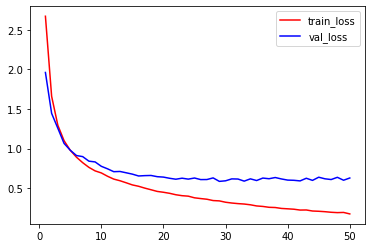

In [64]:
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'r', label='train_loss')
plt.plot(epochs, val_losses, 'b', label='val_loss')
plt.legend()
plt.show()

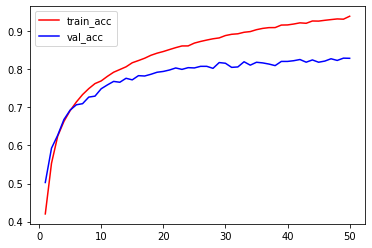

In [63]:
plt.plot(epochs, train_accs, 'r', label='train_acc')
plt.plot(epochs, val_accs, 'b', label='val_acc')
plt.legend()
plt.show()

In [17]:
model.eval()
result = torch.LongTensor()
for data, label in tqdm(test_loader):
    if torch.cuda.is_available():
        data = Variable(data).cuda()
        label = Variable(label).cuda()
    else:
        data = Variable(data)
        label = Variable(label)
    
    out = model(data)
    _, pred = torch.max(out, 1)
    result = torch.cat((result, pred.cpu()), dim=0)

100%|█████████████████████████████| 4688/4688 [09:11<00:00,  8.50it/s]


In [18]:
result

tensor([4, 6, 2,  ..., 9, 6, 6])

In [34]:
images = os.listdir('E:\\DL_datasets\\cifar10\\test\\other')
result_df = pd.DataFrame({'id':images, 'label':result})

In [35]:
result_df.head()

,id,label
0,1.png,4
1,10.png,6
2,100.png,2
3,1000.png,4
4,10000.png,6


In [45]:
result_df['id'] = result_df.id.apply(lambda x: x.split('.')[0])
labels = train_dataset.classes
result_df['label'] = result_df.label.apply(lambda x: labels[x])
result_df.to_csv('20190919_submission.csv', index=False)

In [27]:
print(train_dataset.classes)
train_dataset.class_to_idx

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

参考链接：
1. PyTorch识别CIFAR10：https://www.cnblogs.com/zhengbiqing/p/10432169.html